# Notebook for å hente ut fra Edith og lagre data i ønsket format

## Oppskrift:
* Hent inn pakker
* koble opp til sqlite-databasen
* Les "rådata" og editerte data
* Koble dataene


* Velg riktig celle i notebooken for å skrive ut til ønsket format


In [ ]:
#Henter inn pakkene som trengs. Trenger pandas og sqlite3

import pandas as pd

import sqlite3
from sqlalchemy import Table, create_engine
from sqlalchemy.sql import select
from flask_sqlalchemy import SQLAlchemy
import json

## Laster inn forhåndsdefinert config.json
#### Fila må være fylt ut med riktige parametre og ligge i samme mappe som denne notebook'en

In [ ]:
# Config-fil

with open("config.json") as config: # Laster in valg fra config.json
    config = json.load(config)

In [ ]:
# Kobler opp til sqlite-databasen
# OBS! Sjekk at navn på databasen og filsti er korrekt i config.json! Eks /home/db/edith.sqlite eller /ssb/bruker/...

# Funksjon for å opprette sqlite-database og etablere "connection". 

def connect():
    engine = create_engine(f"sqlite:///{config['data']['filsti']}/edith.sqlite")
    conn = sqlite3.connect(f"{config['data']['filsti']}/edith.sqlite", timeout=15) #Må endres hvis koblingen skal være opp mot dynarev
    db = SQLAlchemy()
    return conn, engine, db


In [ ]:
conn, engine, db = connect()

In [ ]:
# Setter parametre som trengs
#1) Tabellene i sqlite-databasen som inneholder rådata og editerte data
raadata_tabell = "raadata"
edit_tabell = "editeringer"

#2) Filsti og filnavn på ut-data. Filnavn får riktig "hale" utfra valgt ut-metode
filsti = "/ssb/stammexx/<stammenavn>"
filnavn = "editerte_fra_edith"

In [ ]:
raadata_select = "SELECT * FROM "+ raadata_tabell
#raadata_select = "SELECT * FROM "+ raadata_tabell+ " WHERE orgnr='xx'" 

edit_select = "SELECT * FROM "+ edit_tabell
#edit_select = "SELECT * FROM "+ edit_tabell+ " WHERE orgnr='xx'" 


In [ ]:
### Koble sammen raadata og editerte data

df_ut = pd.read_sql(raadata_select, con=engine)
df_e = pd.read_sql(edit_select, con=engine) 
df_ut = pd.concat([df_ut, df_e])
df_ut = df_ut.sort_values(by="Log_tid", ascending=False)
df_ut = df_ut.drop_duplicates(subset=["VARIABEL", "ORGNR"], keep="first")
    
df_ut.drop('index',1,inplace=True)

#df_ut.head()

## Nedenfor følger celler for ulike utskriftsmuligheter. Kjør den som gir ønsket filformat

1) Til CSV

2) Til json

3) Til parquet

4) Tilbakeføring til ISEE Dynarev

In [ ]:
## 1) CSV
utfil = filsti+filnavn+".csv"

df_ut.to_csv(utfil, sep=';', index=False, encoding='UTF-8')


In [ ]:
## 2) JSON
utfil = filsti+filnavn+".json"

df_ut.to_json(utfil, orient='table', index = False)

In [ ]:
# 3) Skrive til parquet
utfil = filsti+filnavn+".parquet"

df_ut.to_parquet(utfil)

## DYNAREV-kode

### For å kunne tilbakeføre editerte data til Dynarev kan man ta i bruk funksjonalitet i ISEE for automatisk oppdatering. Denne funksjonaliteten ble opprinnelig laget for editering i SAS, men er også tilgjengelig fra Python. 

### Forutsetninger for bruk:
* I Kontrollbygger i ISEE må det defineres en egen kontroll av typen SPESIAL_AOSAS med et tilhørende AO_NR: 

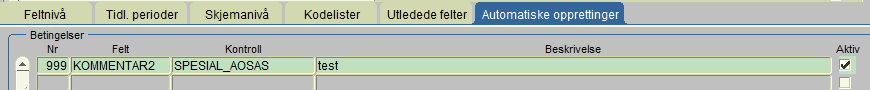

* Det må opprettes en datafil (pandas dataframe) med følgende felter og datatyper:
    - AO_NR       NUMBER         NOT NULL 
    - DELREG_NR   NUMBER         NOT NULL,
    - ENHETS_ID   VARCHAR2(30)   NOT NULL,
    - SKJEMA      VARCHAR2(30)   NOT NULL,
    - LOPENR      NUMBER         NOT NULL,
    - ENHETS_TYPE VARCHAR2(4)    NOT NULL,
    - RAD_NR      NUMBER         NOT NULL,
    - FELT_ID     VARCHAR2(100)  NOT NULL,
    - FELT_VERDI  VARCHAR2(2000)
    
    
* OBS!! Det er viktig at variablene står i ovennevnte rekkefølge
* FELT_ID må ha samme navn som definert i skjemabygger (obs! Store bokstaver)

Mer om AO_SAS: https://wiki-p.ssb.no/display/ISEE/AOSAS+-+Automatisk+oppretting+via+SAS 

### Eksempel på hvordan en rad med data kan se ut
test_data = {'AO_NR':[999],'DELREG_NR':[1234],'ENHETS_ID':['01234567'],'SKJEMA':['RA-xxxx'],'LOPENR':[1], 'ENHETS_TYPE':['BEDR'],
             'RAD_NR':[0],'FELT_ID':['MIN_KOMMENTAR'], 'FELT_VERDI':['Kommentar om enheten']}

xd = pd.DataFrame(test_data)

xd.dtypes

xd

In [ ]:
#Oppkobling til Oracle, oppgi passord sjekk om det er riktig database (DB1P (produksjon)/DB1T(test))

import getpass
import cx_Oracle
db = cx_Oracle.connect(getpass.getuser(),getpass.getpass(), "DB1P")
cur = db.cursor()

In [ ]:
# Selekterer KUN de editerte dataene som skal lastes tilbake til ISEE

df_isee = pd.read_sql(edit_select, con=engine) 
df_isee = df_e.sort_values(by="Log_tid", ascending=False)
df_isee = df_e.drop_duplicates(subset=["VARIABEL", "ORGNR"], keep="first")

# Sørger for at editerte verdier er heltall - Ikke sikkert dette er riktig for alle statistikker!!!
for i in config['perioder']:
    df_isee[config['perioder'][i]['periode']] = df_isee[config['perioder'][i]['periode']].astype(int)

df_isee.head()

In [ ]:
# Fjerner unødvendige variabler - STATISTIKKSPESIFIKT!

df_isee.drop(['februar','januar','ORG_FORM','NACE1'],1,inplace=True)

# For å kunne skrive tilbake til ISEE må disse variablene finnes - FELT_ID og FELT_VERDI
df_isee['FELT_ID'] = df_isee['VARIABEL']
df_isee['FELT_VERDI'] = df_isee['mars']

# AO_NR må være definert i Kontrollbyggeren, se dokumentasjon. Samme nr må inn her
df_isee['AO_NR'] = 999
df_isee.head()

In [ ]:

# OBS!! Datasettet MÅ inneholde alle variable i denne rekkefølgen. 
til_isee = df_isee[['AO_NR','DELREG_NR','ENHETS_ID', 'SKJEMA','LOPENR','ENHETS_TYPE','RAD_NR','FELT_ID','FELT_VERDI']]
#til_isee.head()

In [ ]:
# Setter inn dataene i view: VW_AOSAS_UPDATE
rows = [tuple(x) for x in til_isee.values]
cur.executemany("INSERT INTO DYNAREV.VW_AOSAS_UPDATE VALUES (:1,:2,:3,:4,:5,:6,:7,:8,:9)",rows)
db.commit()
cur.close


In [ ]:
# Kode som kan kjøres for å sjekke at dataene er på plass i oppdateringstabellen
#data = pd.read_sql("SELECT * FROM DYNAREV.VW_AOSAS_UPDATE WHERE DELREG_NR = xxx ", con=db)
#data.head()

In [ ]:
# Lukker databaseforbindelsen
db.close